<a href="https://colab.research.google.com/github/BI-DS/EBA-3530/blob/main/Lecture_2/spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with Spotify data

Spotify assigns 13 different musical attributes/features to each song (see this [link](https://developer.spotify.com/console/get-audio-features-track/)). These song attributes, or features, are used to recommend new music to spotify's users. The features are mostly numerical values. Spotify also assigns a **popularity score** based on the total number of clicks for a given song. Alternatively, you can get a sample from [kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features/home).

The question is: can we classify songs as "popular" based on their musical attributes?

# Threshold on continous variables

We have seen in the lecture that if a response variable $y$ is binary (only takes values 0 and 1), then we can model the conditional expectation

$\mathbb{E}[y|\mathbf{x}]=f(\mathbf{x}'\boldsymbol{\beta})$

using the logit function $\log (p/(1-p))$ we obtain

$\mu=f(\mathbf{x}'\boldsymbol{\beta})=\frac{exp(\mathbf{x}'\boldsymbol{\beta})}{1+exp(\mathbf{x}'\boldsymbol{\beta})}$.

We can convert any continous variable $y$ into a binary response by defining a **thershold** value. That is, if y > thershold then y = 1, else y = 0.

# Log odds or Probablity
Make sure  you understand the difference between:
* $\log \frac{p}{1-p} = x'\beta$
* $p(y=1|x) = \frac{\exp{x'\beta}}{1+ \exp{x'\beta}}$

In [ ]:
# load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# this is the address where the data is at github
url = 'https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Lecture_2/spotify.csv'

# load it into a data frame
col_names = ['artist', 'track_id', 'track_name', 'acousticness', 'danceability',
             'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
             'loudness','mode', 'speechiness', 'tempo', 'time_signature',
             'valence', 'popularity']

# read csv file
df = pd.read_csv(url, delimiter=',', names=col_names, header=1)
print('The data set has {} observations, with {} features each.'.\
      format(df.shape[0],df.shape[1]))

The data set has 130662 observations, with 17 features each.


In [ ]:
# so lets definy a threhold for the popularity socre at spotify
threshold = 35

In [ ]:
# I am defining a function to plot a density function
def plot_density(df, thershold):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    # plot density
    sns.histplot(df['popularity'], color='g', label="Popularity Score",\
                 kde=True, stat="density", linewidth=0, bins=25)\
               .set_title("Distribution of Popularity Scores - Entire Data Set")
    # plot the threshold
    plt.vlines(threshold, 0, 0.05, colors='r', label='Threshold')

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

# Visualizing the data
It is always necessary to look at the data before any model is fitted. Histograms, scatter plots, qq-plots, violin plots, etc. are a good way to understand the data and reveal extreme values (outliers), missing values, or any other error.

## Density functions

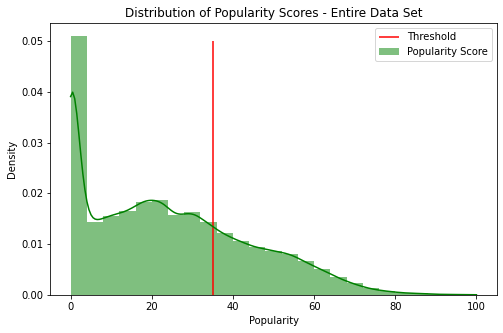

In [ ]:
# use the function that we defined above
# and plot the score density together with
# our threshold to create a binary response y
plot_density(df, threshold)

## Scatter plots

It is always a good idea to look into scatter plots to see, for example, if two variables are highly correlated. The function `pairplot`in the library `seaborn` is perfect for such visualization.

In [ ]:
# Again, I just create a funtion to deal with
# the scatter plots. Alternativelly, you can just
# run line by line (in a non function manner).
def plot_pairplot(df, cutoff, columns):
    # make a copy of original df so we
    # dont modify our original dataframe
    df = df.copy()

    # define binary variable based on a given cutoff
    df['is_popular'] = np.where(df['popularity'] > cutoff,"Popular", "Not_Popular")

    # plot grid of pair scatterplots
    # variable "hue" is used to separate the data
    sns.pairplot(df.loc[:100000, columns], hue='is_popular', height=2)

    plt.show()

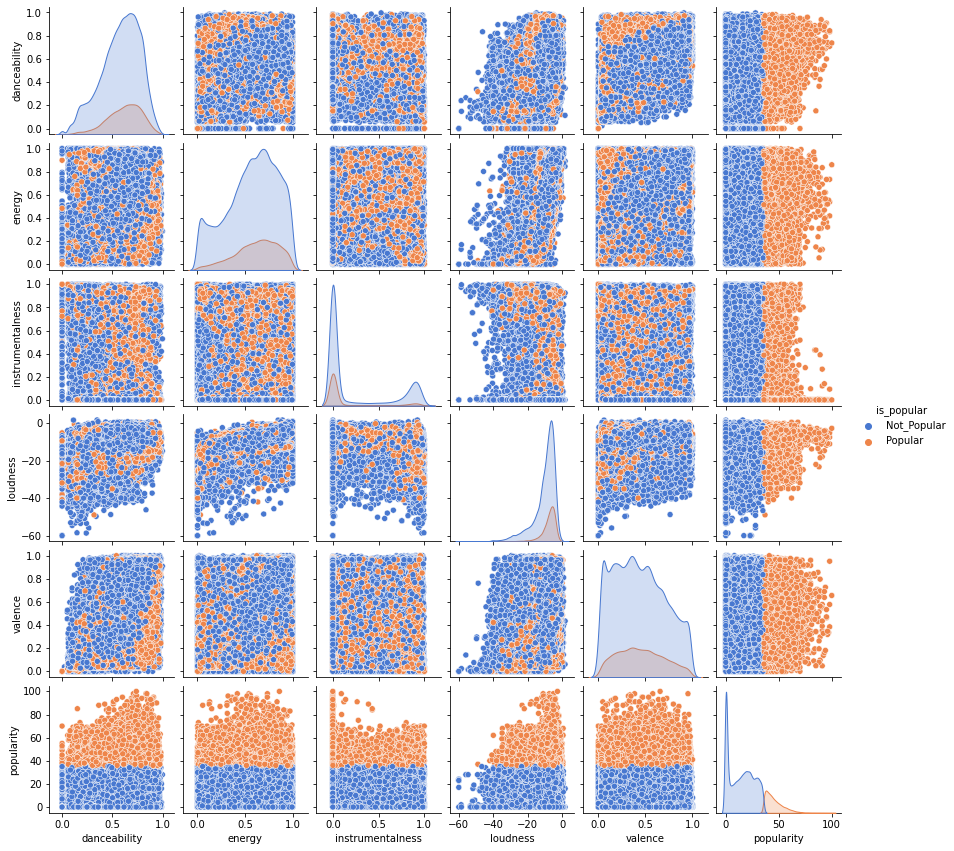

In [ ]:
#select some columns to visualize
columns = ['danceability', 'energy', 'instrumentalness',
           'loudness','valence', 'popularity', 'is_popular']

# plot scatter plots
plot_pairplot(df,threshold,columns)

## Violin plots
Violin plots depict i) the median (the white dot), ii) the interquartile range (gray dots), iii) the distribution excluding outliers (gray line), and iv) the shape of the data distribution (based on a kernel estimation).

In [ ]:
def plot_violin(df, threshold):
    df = df.copy()

    sns.set(style="whitegrid")
    df['pop_bin'] = np.where(df['popularity'] > threshold, "Popular", "Not_Popular")

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    fig.suptitle('Distributions for some selected features at a {} popularity threshold'\
                 .format(threshold))

    sns.violinplot(x=df['pop_bin'], y=df['danceability'], ax=ax[0]).set(xlabel=None)
    sns.violinplot(x=df['pop_bin'], y=df['valence'], ax=ax[1]).set(xlabel=None)
    sns.violinplot(x=df['pop_bin'], y=df['acousticness'], ax=ax[2]).set(xlabel=None)

    plt.show()

    sns.set(style="whitegrid")

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    fig.suptitle('Distributions for some selected features at a {} popularity threshold'\
                 .format(threshold))

    sns.violinplot(x=df['pop_bin'], y=df['energy'], ax=ax[0]).set(xlabel=None)
    sns.violinplot(x=df['pop_bin'], y=df['instrumentalness'], ax=ax[1]).set(xlabel=None)
    sns.violinplot(x=df['pop_bin'], y=df['liveness'], ax=ax[2]).set(xlabel=None)

    plt.show()

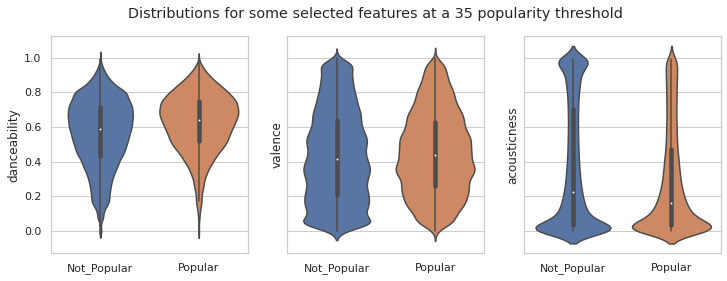

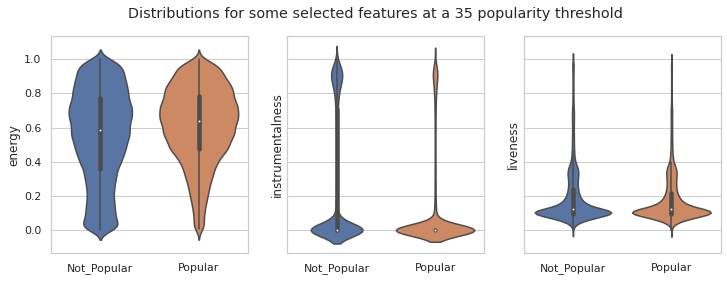

In [ ]:
plot_violin(df, threshold)

# Fitting a logistic regression
The idea is to use the thersehold on the continous popularity score to derive a binary response variable $y$. Then, using the song features, we classify songs into *popular* or *not popular*.

In [ ]:
# features to use as predictors/covariates
x = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness'
     ,'liveness','loudness','mode','speechiness','tempo','time_signature','valence']

# define y
df['pop_bin'] = np.where(df['popularity'] > threshold, 1, 0)
y = ['pop_bin']

# get x and y
x = df[x]
y = df[y]

# split the data into training and test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)
for train_index, test_index in sss.split(x, y):
    x_tr, x_te = x.iloc[train_index], x.iloc[test_index]
    y_tr, y_te = y.iloc[train_index], y.iloc[test_index]


Let's first fit a logistic regression with all covariates and no intercept $\beta_0$. That is, we assume, or force, that $\beta_0 = 0$.

In [ ]:
# define the loggistic regression model
logistic_regression = sm.Logit(y_tr, x_tr)
fitted_model = logistic_regression.fit()
print(fitted_model.summary())

Optimization terminated successfully.
         Current function value: 0.547663
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                pop_bin   No. Observations:                91463
Model:                          Logit   Df Residuals:                    91451
Method:                           MLE   Df Model:                           11
Date:                Wed, 19 Jan 2022   Pseudo R-squ.:                 0.07239
Time:                        09:26:27   Log-Likelihood:                -50091.
converged:                       True   LL-Null:                       -54000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness         0.1114      0.032      3.459      0.001       0.048       0.174
danceabilit

Now lets add the intercept term $\beta_0$.

In [ ]:
# now add an intercept (beta_0) by adding a
# column of 1's to the covariates x
x_tr_intercept = sm.add_constant(x_tr)
logistic_regression2 = sm.Logit(y_tr, x_tr_intercept)
fitted_model2 = logistic_regression2.fit()
print(fitted_model2.summary())

Optimization terminated successfully.
         Current function value: 0.547419
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                pop_bin   No. Observations:                91463
Model:                          Logit   Df Residuals:                    91450
Method:                           MLE   Df Model:                           12
Date:                Wed, 19 Jan 2022   Pseudo R-squ.:                 0.07280
Time:                        09:28:08   Log-Likelihood:                -50069.
converged:                       True   LL-Null:                       -54000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7252      0.108      6.723      0.000       0.514       0.937
acousticnes

After we have trained our logistic regression model, we can predict the probablity $p(y=1|x)$ using the inbuild `predict`method in the `Logit` model.

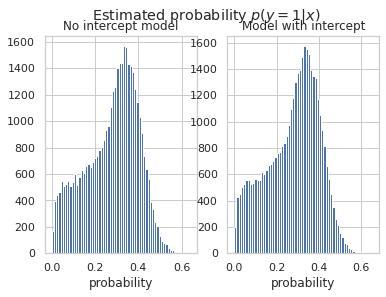

In [ ]:
# test the logistic regression on unseen songs
# i.e. the test data set
mu1 = fitted_model.predict(x_te)
mu2 = fitted_model2.predict(sm.add_constant(x_te))

# lets visualize the score
fig, ax = plt.subplots(1,2)

_ = ax[0].hist(mu1,bins='auto')
_ = ax[1].hist(mu2,bins='auto')
ax[0].set(title=r'No intercept model')
ax[0].set(xlabel='probability')
ax[1].set(xlabel='probability')
ax[1].set(title=r'Model with intercept')
plt.suptitle('Estimated probability $p(y=1|x)$')
plt.show()